In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models import resnet50, ResNet50_Weights
import cv2

### Image Example for Visualization

In [3]:
# from PIL import Image

# img = Image.open('./InstanceSeg/ImageSeg/val/Europa_Ice_Blocks_gg_ff_1615_7527_15.png')
# print(img.size)
# img

### Mask Example for Visualization

(250, 250) (array([  1,  32,  36,  68,  84, 140, 144, 231, 253, 255], dtype=uint8), array([60445,  1279,   776, 60445, 60445,  1279,  1279,   776,   776,
       62500]))


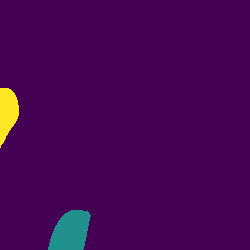

In [2]:
mask = Image.open('./InstanceSeg/MaskSeg/val/Europa_Ice_Blocks_kk-hh_2956_3473_1.png')

# each mask instance has a different color, from zero to N, where
# N is the number of instances.
print(mask.size, np.unique(mask, return_counts=True))
mask

In [27]:
import matplotlib.image as mpimg
mask_array = mpimg.imread('./InstanceSeg/MaskSeg/val/Europa_Ice_Blocks_gg_ff_1615_7527_15.png')
print(np.unique(mask_array, return_counts=True))

(array([0.00392157, 0.1254902 , 0.14117648, 0.22745098, 0.26666668,
       0.32156864, 0.32941177, 0.36862746, 0.38039216, 0.54509807,
       0.54901963, 0.5647059 , 0.7882353 , 0.90588236, 0.99215686,
       1.        ], dtype=float32), array([49729,  2533,  2607,  3826, 49729,  3826, 49729,  3805,  3805,
        3826,  2533,  2533,  3805,  2607,  2607, 62500]))


In [2]:
class EuropaIceBlockDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, train=0):
        self.root = root
        self.transforms = transforms
        self.train = train
        if self.train==0:
            self.imgs = list(sorted(os.listdir(os.path.join(root, "ImageSeg/train"))))
            self.masks = list(sorted(os.listdir(os.path.join(root, "MaskSeg/train"))))
        elif self.train==1:
            self.imgs = list(sorted(os.listdir(os.path.join(root, "ImageSeg/val"))))
            self.masks = list(sorted(os.listdir(os.path.join(root, "MaskSeg/val"))))
        else:
            self.imgs = list(sorted(os.listdir(os.path.join(root, "ImageSeg/test"))))
            self.masks = list(sorted(os.listdir(os.path.join(root, "MaskSeg/test"))))
    def __getitem__(self, idx):
        if self.train==0:
            img_path = os.path.join(self.root, "ImageSeg/train", self.imgs[idx])
            mask_path = os.path.join(self.root, "MaskSeg/train", self.masks[idx])
        elif self.train==1:
            img_path = os.path.join(self.root, "ImageSeg/val", self.imgs[idx])
            mask_path = os.path.join(self.root, "MaskSeg/val", self.masks[idx])
        else:
            img_path = os.path.join(self.root, "ImageSeg/test", self.imgs[idx])
            mask_path = os.path.join(self.root, "MaskSeg/test", self.masks[idx])
        img = Image.open(img_path).convert("RGB") 
        img_array = np.array(img)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)# Threw an index error! np.array(mask)[:,:,1]
       
        # instances are encoded as different colors  
        obj_ids = np.unique(mask)
        # first id is the background, so remove it 
        obj_ids =  obj_ids[1:]
        # split the color-encoded mask into a set  of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          if xmin<xmax and ymin<ymax:
            boxes.append([xmin, ymin, xmax, ymax])
        num_boxes = len(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_boxes,), dtype=torch.int64) 
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        try: 
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # Error thrown here by number of images: https://discuss.pytorch.org/t/how-to-solve-indexerror-too-many-indices-for-tensor-of-dimension-1/40168/3
        except IndexError:
            area = (0)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_boxes,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [3]:
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT, 
                                                               box_score_thresh=0.5, 
                                                               trainable_backbone_layers=3)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)
    return model

In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
dataset = EuropaIceBlockDataset('InstanceSeg', get_transform(train=True),0)
dataset_test = EuropaIceBlockDataset('InstanceSeg', get_transform(train=False),1)
model = torch.load("mask-rcnn-ice-block_2023-05-23_19-17-45.pt")

In [6]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4,
                                          collate_fn=utils.collate_fn) 

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4,
                                               collate_fn=utils.collate_fn) 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_instance_segmentation_model(num_classes)
#model = torch.load("mask-rcnn-ice-block_2023-05-23_19-17-45.pt")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) 

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=150,gamma=0.1) 
num_epochs = 150

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

ValueError: num_samples should be a positive integer value, but got num_samples=0

## Loss Visualization

In [31]:
l_list = []
num_epochs = 200
model.train() 
for i in range(num_epochs): 
    for images, targets in data_loader: 
        images = list(image.to(device) for image in images) 
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets] 
        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values()) 
        optimizer.zero_grad() 
        losses.backward() 
        optimizer.step() 
    l_list.append(losses.cpu().detach().numpy())
epochs = np.arange(num_epochs)

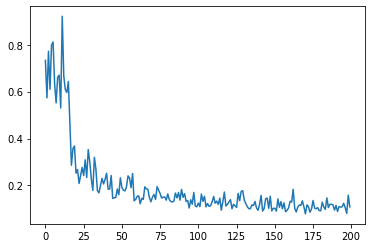

In [32]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epochs, l_list)
plt.show()

In [7]:
## Saving Model Weights for checkpoints
import datetime
nowstr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model, f'mask-rcnn-ice-block_{nowstr}.pt')

In [11]:
# pick one image from the test set
#img, _ = dataset_test[1]
# put the model in evaluation mode
model = torch.load("mask-rcnn-ice-block_2023-05-23_19-17-45.pt")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [7]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

NameError: name 'img' is not defined

In [8]:
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy())

NameError: name 'prediction' is not defined

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def imshow(inp, pred):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(1, figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
    for i in range(pred.shape[0]):
      color = ['r', 'y', 'b', 'g']
      width = prediction[0]["boxes"][i][2] - prediction[0]["boxes"][i][0]
      height = prediction[0]["boxes"][i][3] - prediction[0]["boxes"][i][1]
      rect = patches.Rectangle((prediction[0]["boxes"][i][0], prediction[0]["boxes"][i][1]), width, height, linewidth = 2, edgecolor = color[i%4], facecolor = 'none', alpha=0.9)
      ax.add_patch(rect)
    ax.imshow(inp)

imshow(torchvision.utils.make_grid(img), prediction[0]["boxes"])
print(len(prediction[0]['scores']))

4


# Validation Dataset Predictions

True Positives:  32.0 False Negatives:  1282.0 False Positives:  1009.0 True Negatives:  60177.0 IoU:  0.013775290572535515
True Positives:  2927.0 False Negatives:  575.0 False Positives:  1258.0 True Negatives:  57740.0 IoU:  0.6149159663865547
True Positives:  3303.0 False Negatives:  2725.0 False Positives:  910.0 True Negatives:  55562.0 IoU:  0.47607379648313636
True Positives:  41.0 False Negatives:  294.0 False Positives:  0.0 True Negatives:  62165.0 IoU:  0.12238805970149254
--------------------------------------------VALIDATION RESULTS--------------------------------------------
Average Precision: 0.8380480669034207
Average Recall: 0.5101640741920269
Average IoU: 0.409051037714573


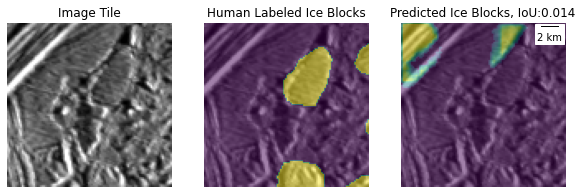

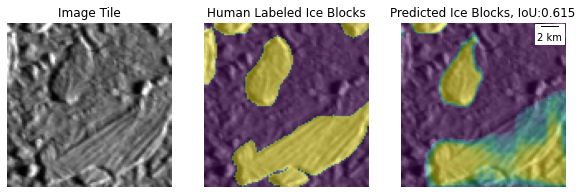

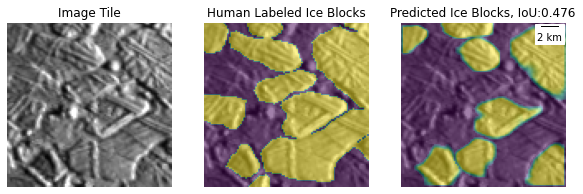

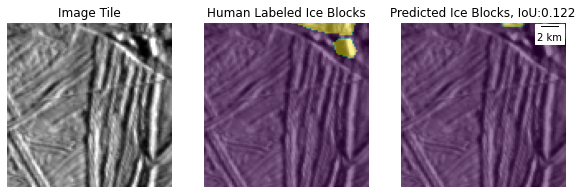

In [14]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

temp_IOU = 0
temp_P = 0
temp_R = 0
for idi, (img,_) in enumerate(dataset_test):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,10))
    scalebar = ScaleBar(179) # 1 pixel = 179 m
    plt.gca().add_artist(scalebar)

    ax1.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax1.set_title("Image Tile")
    ax1.axis('off')
    
    ax2.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax2.imshow(mask_lblz, alpha = 0.5)
    ax2.set_title("Human Labeled Ice Blocks")
    ax2.axis('off')
    
    mask_lblz = np.zeros((img.shape[1],img.shape[1]))
    mask_pred = np.zeros((img.shape[1],img.shape[1]))
    for i in range(len(dataset_test[idi][1]['masks'].numpy())):
        lblz = dataset_test[idi][1]['masks'].numpy()[i]
        mask_x, mask_y = np.where(lblz == 1)
        for x in range(len(mask_x)):
            mask_lblz[mask_x[x]][mask_y[x]] = lblz[mask_x[x]][mask_y[x]]

    ax3.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax3.axis('off')
    
    for i in range(len(np.array(prediction[0]['masks'].mul(255).byte().cpu().numpy()))):
        predz = np.array(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
        mask_x, mask_y = np.where(predz >= 50)
        for x in range(len(mask_x)):
            mask_pred[mask_x[x]][mask_y[x]] = predz[mask_x[x]][mask_y[x]]
            
    ax3.imshow(mask_pred, alpha = 0.5)
    
    # John's Result
    results_j = np.zeros(3)
    img_1 = mask_lblz
    img_2 = mask_pred
    for r in range(img_1.shape[0]):
        for c in range(img_1.shape[1]):
            if (img_1[r,c] >0) and (img_2[r,c] >0):
                results_j[0]+=1
            elif img_1[r,c] >0:
                results_j[1]+=1
            elif img_2[r,c] >0:
                results_j[2]+=1 
                
    current_IOU = results_j[0]/(sum(results_j))
    current_P = results_j[0]/(results_j[0] + results_j[2])
    current_R = results_j[0]/(results_j[0] + results_j[1])
    
    temp_IOU+=current_IOU
    temp_P+= current_P
    temp_R+= current_R
    
    print("True Positives: ", results_j[0], "False Negatives: ", results_j[1], "False Positives: ", results_j[2], "True Negatives: ", (250*250)-sum(results_j), "IoU: ", current_IOU)
    ax3.set_title(f"Predicted Ice Blocks, IoU:{round(current_IOU, 3)}")
    
IoU = temp_IOU/idi
AP = temp_P/idi
AR = temp_R/idi
print("--------------------------------------------VALIDATION RESULTS--------------------------------------------")
print("Average Precision:", AP)
print("Average Recall:", AR)
print("Average IoU:", IoU)

## IoU Figures

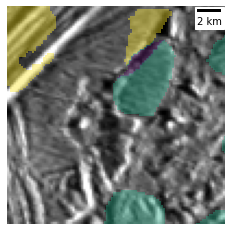

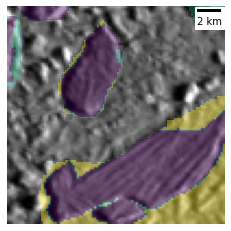

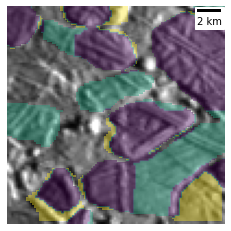

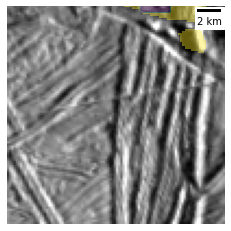

In [15]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
for idi, (img,_) in enumerate(dataset_test):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        
    fig, (ax1) = plt.subplots(1,1, sharex=True, sharey=True)
    scalebar = ScaleBar(179) # 1 pixel = 179 m
    plt.gca().add_artist(scalebar)
    ax1.axis('off')
    both_iou = np.zeros((img.shape[1],img.shape[1]))
    mask_lblz = np.zeros((img.shape[1],img.shape[1]))
    mask_pred = np.zeros((img.shape[1],img.shape[1]))
    
    for i in range(len(dataset_test[idi][1]['masks'].numpy())):
        lblz = dataset_test[idi][1]['masks'].numpy()[i]
        mask_x, mask_y = np.where(lblz == 1)
        for x in range(len(mask_x)):
            mask_lblz[mask_x[x]][mask_y[x]] = lblz[mask_x[x]][mask_y[x]]
            
    for i in range(len(np.array(prediction[0]['masks'].mul(255).byte().cpu().numpy()))):
        predz = np.array(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
        mask_x, mask_y = np.where(predz > 0)
        for x in range(len(mask_x)):
            mask_pred[mask_x[x]][mask_y[x]] = predz[mask_x[x]][mask_y[x]]
            
    img_1 = mask_lblz
    img_2 = mask_pred
    
    for r in range(img_1.shape[0]):
        for c in range(img_1.shape[1]):
            if (img_1[r,c] >0) and (img_2[r,c] >0):
                both_iou[r][c] = -2
            elif img_1[r,c] >0:
                both_iou[r][c] = 1
            elif img_2[r,c] >50:
                both_iou[r][c] = 3
    both_iou = np.ma.masked_where(both_iou == 0, both_iou)
    ax1.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax1.imshow(both_iou, alpha=0.4)

## Prediction on Test Dataset

In [8]:
dataset_val = EuropaIceBlockDataset('InstanceSeg', get_transform(train=False),2)

In [10]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline
temp_IOU = 0
temp_P = 0
temp_R = 0
for idi, (img,_) in enumerate(dataset_val):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,10))
    scalebar = ScaleBar(179) # 1 pixel = 179 m
    plt.gca().add_artist(scalebar)
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax1.set_title("Image Tile")
    ax2.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    mask_lblz = np.zeros((img.shape[1],img.shape[1]))
    mask_pred = np.zeros((img.shape[1],img.shape[1]))
    for i in range(len(dataset_val[idi][1]['masks'].numpy())):
        lblz = dataset_val[idi][1]['masks'].numpy()[i]
        mask_x, mask_y = np.where(lblz == 1)
        for x in range(len(mask_x)):
            mask_lblz[mask_x[x]][mask_y[x]] = lblz[mask_x[x]][mask_y[x]]
    ax2.imshow(mask_lblz, alpha = 0.5)
    # saving the final output 
    # as a PNG file
    ax2.set_title("Human Labeled Ice Blocks")
    ax3.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    for i in range(len(np.array(prediction[0]['masks'].mul(255).byte().cpu().numpy()))):# So that there are as many predictions as there are ice blocks #len(prediction[0]['masks'].mul(255).byte().cpu().numpy())):
        predz = np.array(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
        mask_x, mask_y = np.where(predz >= 50)
        for x in range(len(mask_x)):
            mask_pred[mask_x[x]][mask_y[x]] = predz[mask_x[x]][mask_y[x]]
    ax3.imshow(mask_pred, alpha = 0.5)
    # John's Result
    results_j = np.zeros(3)
    img_1 = mask_lblz
    img_2 = mask_pred
    for r in range(img_1.shape[0]):
        for c in range(img_1.shape[1]):
            if (img_1[r,c] >0) and (img_2[r,c] >0):
                results_j[0]+=1
            elif img_1[r,c] >0:
                results_j[1]+=1
            elif img_2[r,c] >0:
                results_j[2]+=1 
    current_IOU = results_j[0]/(sum(results_j))
    current_P = results_j[0]/(results_j[0] + results_j[2])
    current_R = results_j[0]/(results_j[0] + results_j[1])
    temp_IOU+=current_IOU
    temp_P+= current_P
    temp_R+= current_R
    print("True Positives: ", results_j[0], "False Negatives: ", results_j[1], "False Positives: ", results_j[2], "True Negatives: ", (250*250)-sum(results_j), "IoU: ", current_IOU)
    ax3.set_title(f"Predicted Ice Blocks, IoU:{round(current_IOU, 3)}")
IoU = temp_IOU/idi
AP = temp_P/idi
AR = temp_R/idi
print("--------------------------------------------TEST RESULTS--------------------------------------------")
print("Average Precision:", AP)
print("Average Recall:", AR)
print("Average IoU:", IoU)

NameError: name 'device' is not defined

## IoU Figures

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


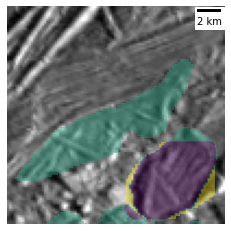

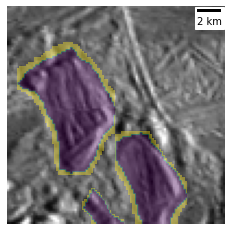

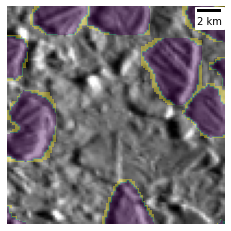

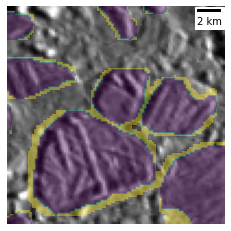

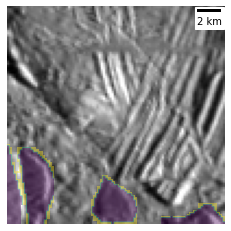

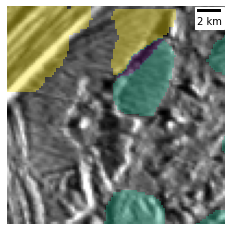

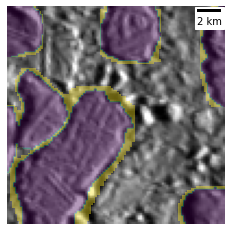

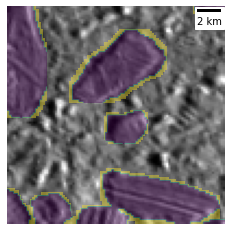

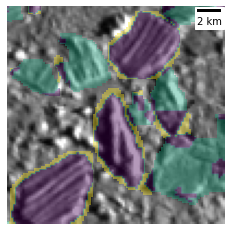

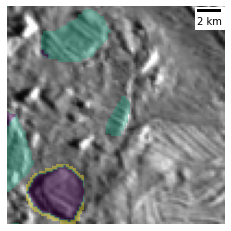

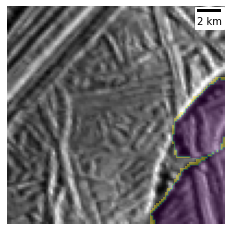

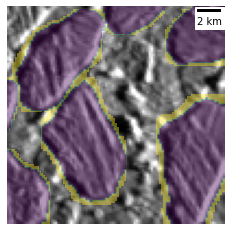

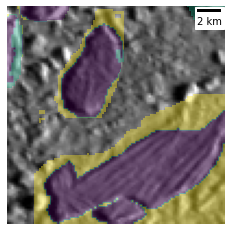

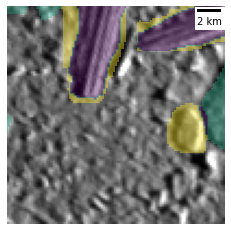

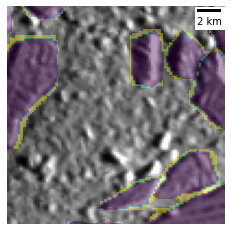

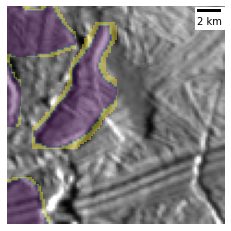

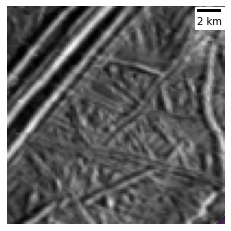

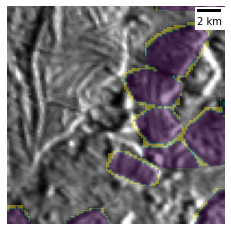

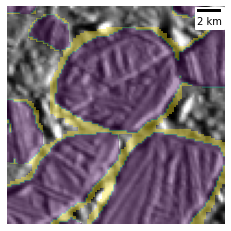

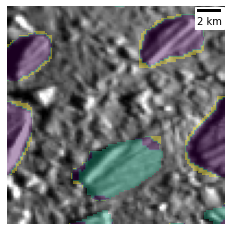

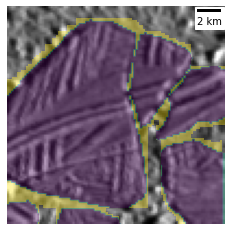

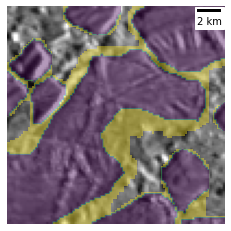

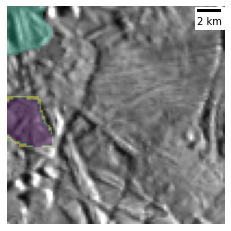

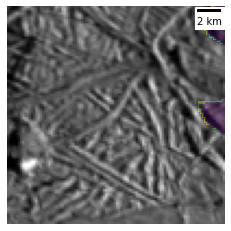

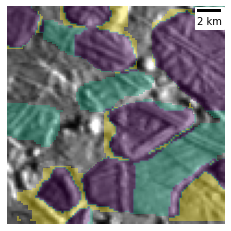

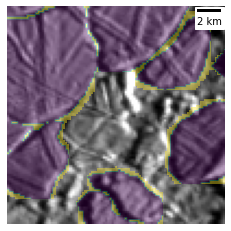

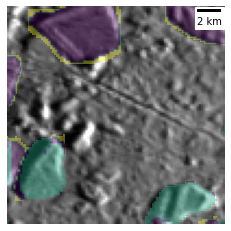

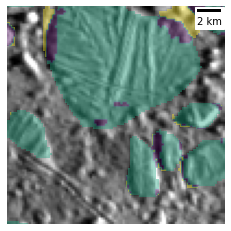

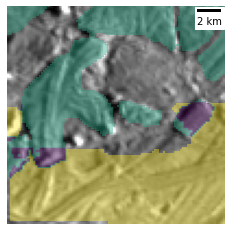

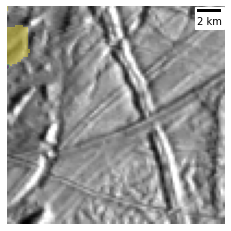

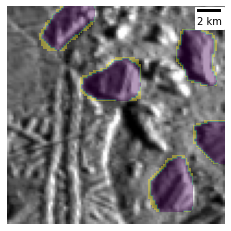

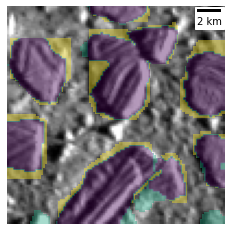

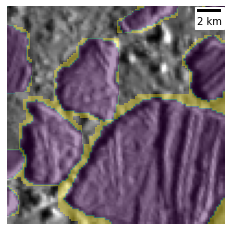

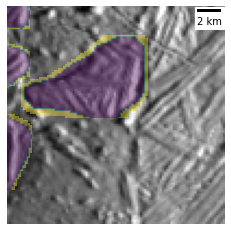

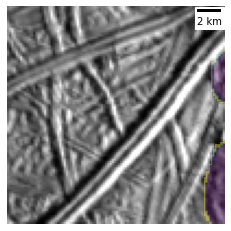

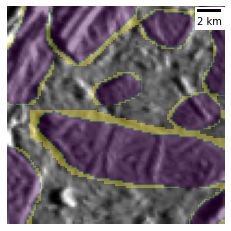

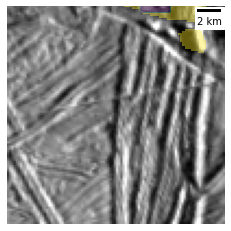

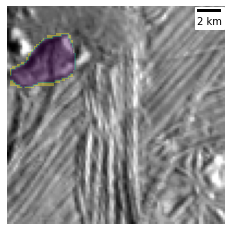

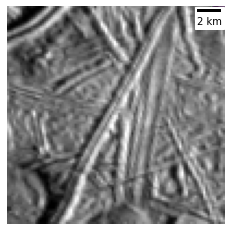

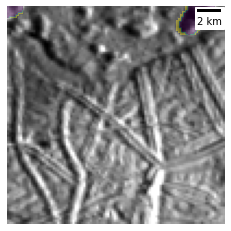

In [115]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
for idi, (img,_) in enumerate(dataset_val):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    fig, (ax1) = plt.subplots(1,1, sharex=True, sharey=True)
    scalebar = ScaleBar(179) # 1 pixel = 179 m
    plt.gca().add_artist(scalebar)
    ax1.axis('off')
    both_iou = np.zeros((img.shape[1],img.shape[1]))
    mask_lblz = np.zeros((img.shape[1],img.shape[1]))
    mask_pred = np.zeros((img.shape[1],img.shape[1]))
    for i in range(len(dataset_val[idi][1]['masks'].numpy())):
        lblz = dataset_val[idi][1]['masks'].numpy()[i]
        mask_x, mask_y = np.where(lblz == 1)
        for x in range(len(mask_x)):
            mask_lblz[mask_x[x]][mask_y[x]] = lblz[mask_x[x]][mask_y[x]]
    for i in range(len(np.array(prediction[0]['masks'].mul(255).byte().cpu().numpy()))):
        predz = np.array(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
        mask_x, mask_y = np.where(predz > 0)
        for x in range(len(mask_x)):
            mask_pred[mask_x[x]][mask_y[x]] = predz[mask_x[x]][mask_y[x]]
    img_1 = mask_lblz
    img_2 = mask_pred
    for r in range(img_1.shape[0]):
        for c in range(img_1.shape[1]):
            if (img_1[r,c] >0) and (img_2[r,c] >0):
                both_iou[r][c] = -2
            elif img_1[r,c] >0:
                both_iou[r][c] = 1
            elif img_2[r,c] >0:
                both_iou[r][c] = 3
    both_iou = np.ma.masked_where(both_iou == 0, both_iou)
    ax1.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax1.imshow(both_iou, alpha=0.4)

## Calculating Area

### ML Predictions

In [15]:
pred_plates=[]
for idi, (img,_) in enumerate(dataset_val):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    resolution = 0.179 # 1 pixel = 179 m
    pred_array = prediction[0]['masks'].cpu().numpy().astype(float)
    for block in range(len(pred_array)):
        pred_cnt=0
        for column in range(len(pred_array[block])):
            for row in range(len(pred_array[block][column])):
                for pixel in pred_array[block][column][row]:
                    if pixel != 0:
                        pred_cnt+=1
        pred_plates.append(round((pred_cnt*resolution*resolution),2))

print(pred_plates)

[48.45, 91.38, 10.89, 46.84, 25.06, 16.82, 13.46, 12.11, 7.05, 16.66, 29.73, 3.59, 10.89, 2.6, 0.29, 25.12, 20.51, 9.74, 96.12, 33.45, 5.83, 1.54, 2.69, 37.74, 1.44, 20.76, 16.21, 9.61, 8.3, 97.47, 46.24, 25.09, 4.97, 29.64, 118.94, 18.07, 12.69, 13.07, 31.66, 7.5, 9.61, 5.99, 4.81, 51.59, 11.44, 46.65, 1.06, 38.45, 20.09, 42.49, 56.23, 26.95, 7.63, 9.61, 0.9, 34.86, 17.49, 2.05, 26.02, 28.32, 16.24, 8.75, 30.44, 40.37, 25.12, 22.43, 61.52, 13.46, 64.59, 4.17, 76.9, 5.61, 50.66, 8.2, 169.18, 14.61, 27.59, 43.26, 21.31, 20.15, 4.93, 40.76, 23.84, 14.87, 14.61, 15.8, 5.64, 1.25, 1.73, 21.15, 75.62, 24.61, 7.18, 14.1, 0.8, 24.99, 17.94, 5.38, 17.65, 3.08, 12.56, 14.0, 8.17, 3.17, 13.62, 0.51, 16.89, 22.85, 90.23, 71.64, 11.53, 2.88, 1.79, 99.33, 1.54, 1.83, 13.46, 25.83, 5.64, 23.13, 16.15, 42.71, 3.84, 0.77, 7.69, 35.89, 37.17, 183.27, 5.77, 43.26, 19.22, 22.11, 12.56, 12.53, 2.82, 244.34, 7.05, 14.13, 43.26, 2.88, 16.15, 16.15, 6.92, 7.08, 22.3, 51.2, 39.03, 10.89, 29.41, 10.25, 23.33, 

In [17]:
with open(r'./plate_areas.txt', 'w') as fp:
    fp.write("\n".join(str(item) for item in pred_plates))

### Human Labels (Sanity Check)

In [119]:
lbl_plates=[]
in_dir_lbl = "./InstanceSeg/MaskSeg/test/"
for filename in os.listdir(in_dir_lbl):
    if filename.endswith(".png"):
        val_img = np.array(Image.open('{}{}'.format(in_dir_lbl,filename)))
        arr = np.array(np.unique(val_img, return_counts=True))
        arr = np.delete(arr, 0, 0)
        arr = np.delete(arr, 0)
        arr = arr.tolist()
        for value in arr:
            lbl_plates.append(round(value*resolution*resolution, 2))
len(lbl_plates)

261

## Prediction on Entire Conomara Reigon

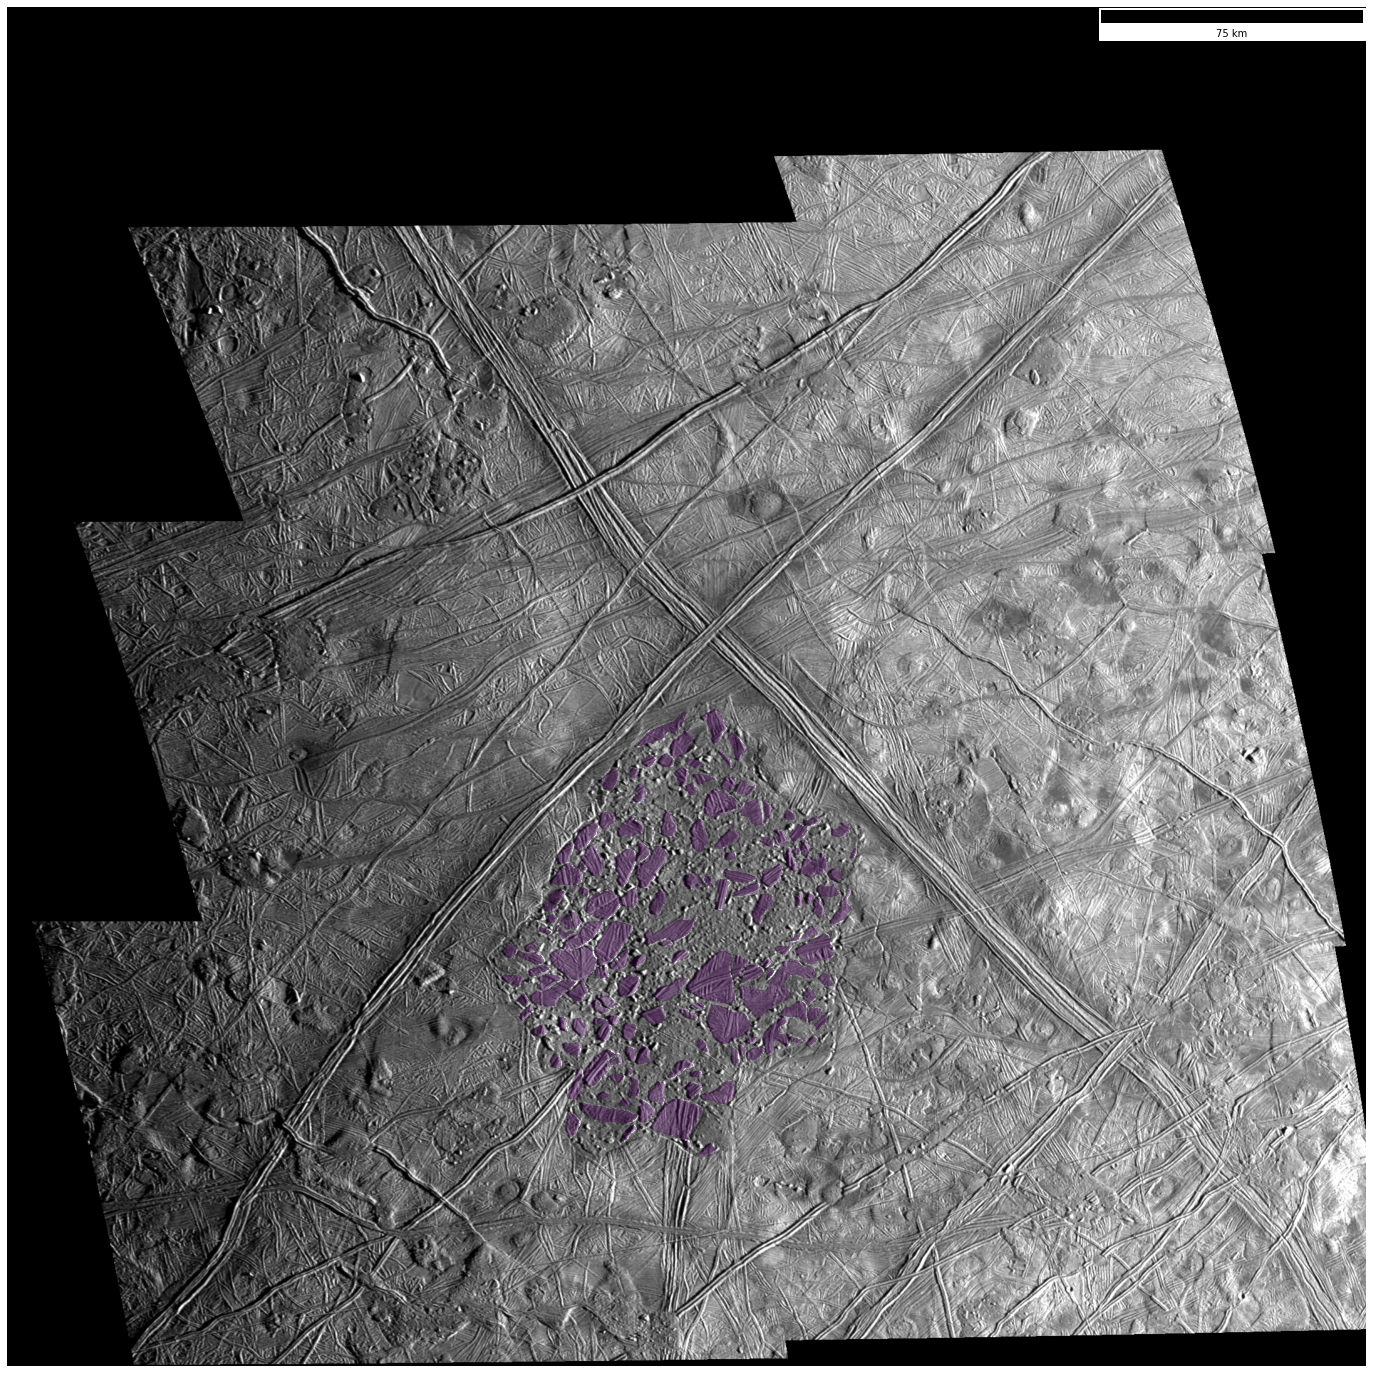

In [99]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
for idi, (img,_) in enumerate(dataset_val):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        
    fig, (ax1) = plt.subplots(1,1, sharex=True, sharey=True, figsize=(25,25))
    scalebar = ScaleBar(179) # 1 pixel = 179 m
    plt.gca().add_artist(scalebar)
    ax1.axis('off')
    both_iou = np.zeros((img.shape[1],img.shape[1]))
    mask_lblz = np.zeros((img.shape[1],img.shape[1]))
    mask_pred = np.zeros((img.shape[1],img.shape[1]))
    for i in range(len(dataset_val[idi][1]['masks'].numpy())):
        lblz = dataset_val[idi][1]['masks'].numpy()[i]
        mask_x, mask_y = np.where(lblz == 1)
        for x in range(len(mask_x)):
            mask_lblz[mask_x[x]][mask_y[x]] = lblz[mask_x[x]][mask_y[x]]
    for i in range(len(np.array(prediction[0]['masks'].mul(255).byte().cpu().numpy()))):
        predz = np.array(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
        mask_x, mask_y = np.where(predz > 0)
        for x in range(len(mask_x)):
            mask_pred[mask_x[x]][mask_y[x]] = predz[mask_x[x]][mask_y[x]]
    img_1 = mask_lblz
    img_2 = mask_pred
    for r in range(img_1.shape[0]):
        for c in range(img_1.shape[1]):
            if (img_1[r,c] >0) and (img_2[r,c] >0):
                both_iou[r][c] = -2
            elif img_1[r,c] >0:
                both_iou[r][c] = 1
            elif img_2[r,c] >0:
                both_iou[r][c] = 3
    both_iou = np.ma.masked_where(both_iou == 0, both_iou)
    ax1.imshow(Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy()))
    ax1.imshow(both_iou, alpha=0.4)

## Repasting Image Tiles onto Conomara Region

ValueError: unknown file extension: .1098]]])

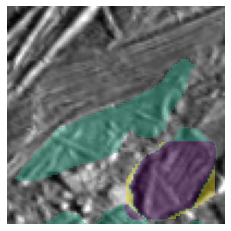

In [14]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
for idi, (img,_) in enumerate(dataset_val):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    fig, (ax1) = plt.subplots(1,1, sharex=True, sharey=True)
    scalebar = ScaleBar(179) # 1 pixel = 179 m
    #plt.gca().add_artist(scalebar)
    ax1.axis('off')
    both_iou = np.zeros((img.shape[1],img.shape[1]))
    mask_lblz = np.zeros((img.shape[1],img.shape[1]))
    mask_pred = np.zeros((img.shape[1],img.shape[1]))
    for i in range(len(dataset_val[idi][1]['masks'].numpy())):
        lblz = dataset_val[idi][1]['masks'].numpy()[i]
        mask_x, mask_y = np.where(lblz == 1)
        for x in range(len(mask_x)):
            mask_lblz[mask_x[x]][mask_y[x]] = lblz[mask_x[x]][mask_y[x]]
    for i in range(len(np.array(prediction[0]['masks'].mul(255).byte().cpu().numpy()))):
        predz = np.array(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
        mask_x, mask_y = np.where(predz > 0)
        for x in range(len(mask_x)):
            mask_pred[mask_x[x]][mask_y[x]] = predz[mask_x[x]][mask_y[x]]
    img_1 = mask_lblz
    img_2 = mask_pred
    for r in range(img_1.shape[0]):
        for c in range(img_1.shape[1]):
            if (img_1[r,c] >0) and (img_2[r,c] >0):
                both_iou[r][c] = -2
            elif img_1[r,c] >0:
                both_iou[r][c] = 1
            elif img_2[r,c] >0:
                both_iou[r][c] = 3
    both_iou = np.ma.masked_where(both_iou == 0, both_iou)
    image = Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())
    ax1.imshow(image)
    ax1.imshow(both_iou, alpha=0.4)
    image2 = Image.fromarray(both_iou)
    mask = Image.new("L", image.size, 128)
    im = Image.composite(image, image2, mask)
    im.save(f"./Ice_Block_ML_Image_Tiles/{img}")

In [31]:
for idi, (img,_) in enumerate(dataset_val):
    print(idi, (img,_))

0 (tensor([[[0.3020, 0.3412, 0.3059,  ..., 0.2039, 0.2784, 0.3333],
         [0.2980, 0.3412, 0.3255,  ..., 0.3412, 0.4471, 0.4980],
         [0.3333, 0.3294, 0.2902,  ..., 0.4941, 0.4980, 0.4745],
         ...,
         [0.1765, 0.1686, 0.1255,  ..., 0.1333, 0.1373, 0.2039],
         [0.2235, 0.2431, 0.2157,  ..., 0.2157, 0.1725, 0.1765],
         [0.3333, 0.3059, 0.2902,  ..., 0.2706, 0.1686, 0.1098]],

        [[0.3020, 0.3412, 0.3059,  ..., 0.2039, 0.2784, 0.3333],
         [0.2980, 0.3412, 0.3255,  ..., 0.3412, 0.4471, 0.4980],
         [0.3333, 0.3294, 0.2902,  ..., 0.4941, 0.4980, 0.4745],
         ...,
         [0.1765, 0.1686, 0.1255,  ..., 0.1333, 0.1373, 0.2039],
         [0.2235, 0.2431, 0.2157,  ..., 0.2157, 0.1725, 0.1765],
         [0.3333, 0.3059, 0.2902,  ..., 0.2706, 0.1686, 0.1098]],

        [[0.3020, 0.3412, 0.3059,  ..., 0.2039, 0.2784, 0.3333],
         [0.2980, 0.3412, 0.3255,  ..., 0.3412, 0.4471, 0.4980],
         [0.3333, 0.3294, 0.2902,  ..., 0.4941, 0.4980,